In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import string
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders.james_stein import JamesSteinEncoder

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_input = pd.read_csv("../data/raw/train.csv")
print(df_input.shape)
df_input.head()

(16784, 30)


,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,73000.0,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,110112.0,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,80000.0,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9800.0,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,40000.0,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0


# Variable Types

In [3]:
target = "price"

In [4]:
cat_vars = [var for var in df_input.columns if df_input[var].dtype == 'O']
cat_vars = cat_vars + ['listing_id']
print (f"length of categorical variables: {len(cat_vars)}")
print (f"categorical variable names: {cat_vars}")
# "original_reg_date", "reg_date", "lifespan" are misclassified, they should belong to date


length of categorical variables: 16
categorical variable names: ['title', 'make', 'model', 'description', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'listing_id']


In [5]:
time_vars = ["original_reg_date", "reg_date", "lifespan", 'manufactured']
for i in time_vars:
    if i in cat_vars:
        cat_vars.remove(i)

In [6]:
df_input[cat_vars] = df_input[cat_vars].astype('O')

In [7]:
num_vars = [
    var for var in df_input.columns if var not in cat_vars+time_vars and var != target
]

print (f"length of numerical variables: {len(num_vars)}")
print (f"numerical variable names: {num_vars}")

length of numerical variables: 12
numerical variable names: ['curb_weight', 'power', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'indicative_price']


# Text features

[description, accessories, features, title, category]
1. length of the descriptions
2. tokenize the words
https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author
3. add target encoding for `category` column

In [8]:
df_input[["description", "accessories", "features", "title", "category"]].head(5)

,description,accessories,features,title,category
0,1 owner! 320i gt m-sports model! big brake kit...,"bmw i-drive, navigation, bluetooth/aux/usb inp...","5 doors gt, powerful and fuel efficient 2.0l t...",BMW 3 Series 320i Gran Turismo M-Sport,"parf car, premium ad car, low mileage car"
1,high loan available! low mileage unit. wear an...,factory radio setting. front recording camera....,low mileage unit. well maintained vehicle. vie...,Toyota Hiace 3.0M,premium ad car
2,1 owner c&c unit. full agent service with 1 mo...,dual electric/memory seats. factory fitted aud...,responsive and fuel efficient 1.6l inline 4 cy...,Mercedes-Benz CLA-Class CLA180,"parf car, premium ad car"
3,"fully agent maintained, 3 years warranty 10 ye...",64 colour ambient lighting. active parking ass...,"1.5l inline-4 twin scroll turbocharged engine,...",Mercedes-Benz E-Class E180 Avantgarde,"parf car, almost new car, consignment car"
4,"kah motor unit! 1 owner, lowest 1.98% for full...","s/rims, premium leather seats, factory touch s...","1.6l i-vtec engine, 123 bhp, earth dreams cvt ...",Honda Civic 1.6A VTi,parf car


- ### category

In [9]:
def _remove_punctuation(word):
    punch = string.punctuation
    for p in punch:
        word = word.replace(p, '')
    word = word.replace('…', '')
    word = word.replace('–', '')
    word = word.replace("’", '')
    return word

In [10]:
def generate_categories(df):
    df["category_clean"] = df["category"].apply(lambda x: 
                                                [_remove_punctuation(i.strip()) for i in x.split(",")]
                                               )

    all_category = []
    for i in df["category_clean"]:
        all_category += i
    all_category_clean = [i for i in list(set(all_category)) if i != '']
    
    return all_category_clean

def add_category_features(df):
    df["category_clean"] = df["category"].apply(lambda x: 
                                                [_remove_punctuation(i.strip()) for i in x.split(",")]
                                               )
    for i in all_category_clean:
        col_name = f"is_{i.replace(' ', '_')}"
        df[col_name] = df["category_clean"].apply(lambda x: np.where(col_name in x, 1, 0))
    
    return df

In [11]:
all_category_clean = generate_categories(df_input)
add_category_features(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_hybrid_cars,is_sgcarmart_warranty_cars,is_premium_ad_car,is_vintage_cars,is_sta_evaluated_car,is_imported_used_vehicle,is_opc_car,is_consignment_car,is_rare__exotic,is_direct_owner_sale
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,0,0,0,0,0,0,0,0,0,0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,0,0,0,0,0,0,0,0,0,0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0,0,0,0,0,0,0,0,0,0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,0,0,0,0,0,0,0,0,0,0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0,0,0,0,0,0,0,0,0,0


- ### title

In [12]:
# title is not a unique column for each listing
print(df_input.shape)
print(len(df_input["title"].unique()))

(16784, 46)
5775


In [13]:
# based on dataset description 
# title - title of the listing; free text attribute typically containing the make, model, engine type/size
df_input[['title', 'make', 'model', 'engine_cap']]

,title,make,model,engine_cap
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1997.0
1,Toyota Hiace 3.0M,NaN,hiace,2982.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1595.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,1497.0
4,Honda Civic 1.6A VTi,NaN,civic,1597.0
...,...,...,...,...
16779,Volvo XC90 T5 Momentum,volvo,xc90,1969.0
16780,Hyundai Ioniq Hybrid 1.6A DCT Sunroof,hyundai,ioniq,1580.0
16781,MINI Cooper Cabriolet 1.6A (COE till 08/2030),mini,cooper,1598.0
16782,Honda Fit 1.3A G F-Package,NaN,fit,1317.0


/Users/user/.pyenv/versions/anaconda3-5.2.0/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


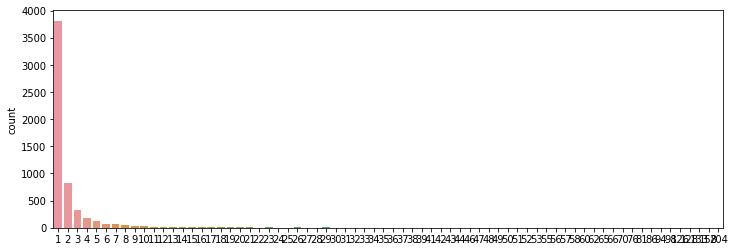

In [14]:
count = df_input["title"].value_counts()
plt.figure(figsize=(12,4))  
sns.countplot(list(count))
plt.show()

Most of the title are unique, or very rare appearance as shown by the high number in low counts. And the title information which includes make, model and engine cap are included in other columns alrdy, this column does give new information thus can possibly be droped.

- ### features, accessories, description

In [15]:
# features are almost unique
print(df_input.shape)
print(len(df_input["features"].unique()))

(16784, 46)
10688


In [17]:
def _remove_stopwords(tokens):
    stopwords_list = stopwords.words('english')
    tokens = [i for i in tokens if i not in stopwords_list]
    return tokens

def _remove_numbers(tokens):
    tokens = [i for i in tokens if not i.isdigit()]
    return tokens

def _to_lower_case(tokens):
    tokens = [word.lower() for word in tokens]
    return tokens

In [18]:
def add_basic_text_features(df):
    text_cols = ["features", "accessories", "description"]
    eng_stopwords = stopwords.words('english')
    
    for col in text_cols:
        df[f"{col}_num_words"] = df[col].apply(lambda x: len(str(x).split()))
        df[f"{col}_num_unique_words"] = df[col].apply(lambda x: len(set(str(x).split())))
        df[f"{col}_num_chars"] = df[col].apply(lambda x: len(str(x)))
        df[f"{col}_num_chars"] = df[col].apply(lambda x: len(str(x)))
        df[f"{col}_num_stopwords"] = df[col].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
        df[f"{col}_num_punctuations"] =df[col].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )        
        df[f"{col}_mean_word_len"] = df[col].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    return df

In [19]:
add_basic_text_features(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,accessories_num_chars,accessories_num_stopwords,accessories_num_punctuations,accessories_mean_word_len,description_num_words,description_num_unique_words,description_num_chars,description_num_stopwords,description_num_punctuations,description_mean_word_len
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,126,1,11,7.466667,47,44,304,8,13,5.489362
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,91,0,4,7.363636,57,52,358,16,11,5.298246
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,142,1,10,6.526316,39,36,228,11,10,4.871795
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,148,0,9,6.842105,21,20,134,4,6,5.428571
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,150,1,10,6.947368,50,44,308,13,13,5.180000


### TF-IDF, word embedding

In [20]:
def generate_tfidf(column_name):
    dataset = list(df_input[column_name].dropna())
    tfIdfTransformer = TfidfTransformer(use_idf=True)
    countVectorizer = CountVectorizer()
    wordCount = countVectorizer.fit_transform(dataset)
    newTfIdf = tfIdfTransformer.fit_transform(wordCount)
    df_features_tfidf = pd.DataFrame(newTfIdf[0].T.todense(), index=countVectorizer.get_feature_names(), columns=["TF-IDF"])
    df_features_tfidf = df_features_tfidf.sort_values('TF-IDF', ascending=False)
    return df_features_tfidf

def build_wordcloud(tfidf_df):
    text = ''
    for word, tfidf in tfidf_df.to_dict()['TF-IDF'].items():
        for i in range(math.ceil(tfidf)):
            text = text + word + ' '

    wordcloud_features = WordCloud(stopwords=STOPWORDS, 
                                   background_color="white",
                                   width=10000, height=5000).generate(text)
    img_demo = plt.imshow(wordcloud_features)
    plt.axis("off")
    plt.show()

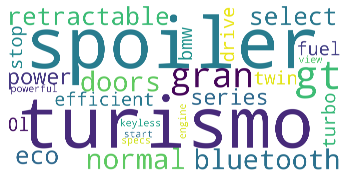

In [21]:
df_features_tfidf = generate_tfidf("features")
build_wordcloud(df_features_tfidf)

In [22]:
print(df_features_tfidf.shape)

(6381, 1)


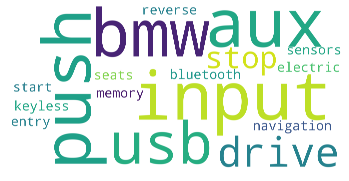

In [23]:
df_accessories_tfidf = generate_tfidf("accessories")
build_wordcloud(df_accessories_tfidf)

In [24]:
print(df_accessories_tfidf.shape)

(5185, 1)


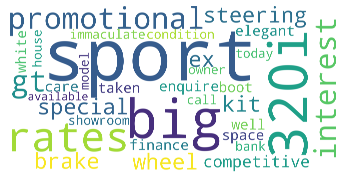

In [25]:
df_description_tfidf = generate_tfidf("description")
build_wordcloud(df_description_tfidf)

In [26]:
print(df_description_tfidf.shape)

(11095, 1)


In [36]:
def tfidf_vectorize(feature_name):
    corpus = list(df_input[feature_name].fillna(""))
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)

#     df_test = pd.DataFrame(X.toarray())
#     df_test.columns = vectorizer.get_feature_names()
    return X

# df_test["price"] = df_input["price"]
# df_corr = df_test.corr()

In [ ]:
# attempt to use t-sne for dimensionality reduction
# very time consuming block t run
# reference: https://distill.pub/2016/misread-tsne/
import numpy as np
from sklearn.manifold import TSNE

# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   init='random').fit_transform(X.toarray())
# X_embedded.shape

In [24]:
# Principal Component Analysis
pca = PCA(2)
pca.fit(X.toarray())
B = pca.transform(X.toarray())
print(B)

[[-2.40808658e-03 -2.02229480e-04 -3.95340099e-03 ... -4.64717408e-05
  -8.33296479e-05 -6.15743446e-05]
 [-2.01459390e-03 -2.13591771e-04  1.18873582e-03 ... -5.69150287e-06
  -3.25495573e-05 -5.24975887e-06]]
[0.02753226 0.02155175]
[[-0.01724248 -0.0641588 ]
 [-0.20481711  0.17572507]
 [ 0.13296262 -0.19756519]
 ...
 [ 0.09282448 -0.09401766]
 [ 0.28669134  0.10785544]
 [-0.14858195 -0.08910248]]


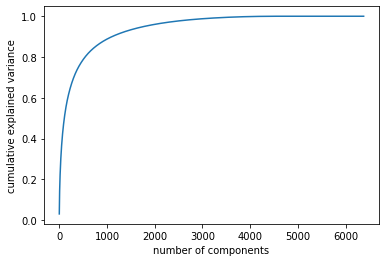

In [29]:
X_features = tfidf_vectorize("features")
pca = PCA().fit(X_features.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [35]:
np.cumsum(pca.explained_variance_ratio_)[500]

0.7873945799211246

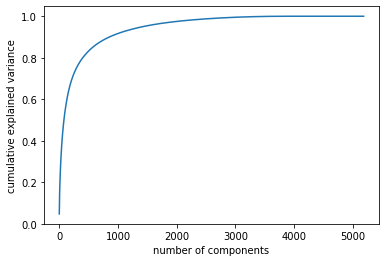

In [37]:
X_accessories = tfidf_vectorize("accessories")
pca = PCA().fit(X_accessories.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

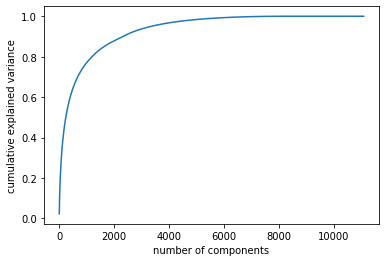

In [38]:
X_description = tfidf_vectorize("description")
pca = PCA().fit(X_description.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### sentiment analysis

In [50]:
def add_sentiment_score(df):
    feature_ls = ["features", "accessories", "description"]
    df[feature_ls] = df[feature_ls].fillna("")
    for i in feature_ls:
        df[f"{i}_sentiment"] = df.apply(lambda x: TextBlob(x[i]).sentiment.polarity, axis=1)
    return df

In [53]:
add_sentiment_score(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,accessories_mean_word_len,description_num_words,description_num_unique_words,description_num_chars,description_num_stopwords,description_num_punctuations,description_mean_word_len,features_sentiment,accessories_sentiment,description_sentiment
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,7.466667,47,44,304,8,13,5.489362,0.225000,0.000000,0.229592
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,7.363636,57,52,358,16,11,5.298246,0.000000,0.000000,0.401250
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,6.526316,39,36,228,11,10,4.871795,0.000000,0.000000,0.531250
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,6.842105,21,20,134,4,6,5.428571,-0.066667,0.133333,0.500000
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,6.947368,50,44,308,13,13,5.180000,0.000000,0.000000,0.440625


In [65]:
sentiment_conl_target = sentiment_conl+["price"]
corr = df_input[sentiment_conl_target].corr()
corr

,features_sentiment,accessories_sentiment,description_sentiment,price
features_sentiment,1.000000,0.074818,0.000862,0.043828
accessories_sentiment,0.074818,1.000000,0.010610,0.078329
description_sentiment,0.000862,0.010610,1.000000,-0.018553
price,0.043828,0.078329,-0.018553,1.000000


Sentiment columns show very weak correlation with the target variables, not really useful features to be included

/Users/user/.pyenv/versions/anaconda3-5.2.0/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


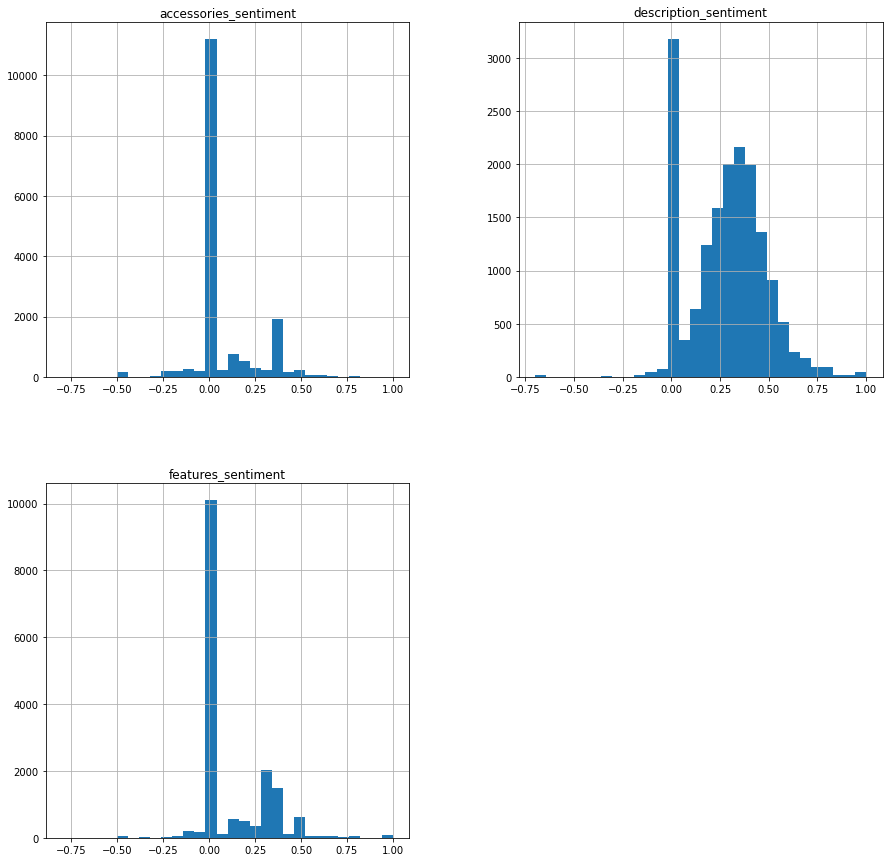

In [52]:
col_ls =["features", "accessories", "description"]
sentiment_conl = [f"{i}_sentiment" for i in col_ls]
df_input[sentiment_conl].hist(bins=30, figsize=(15,15))
plt.show()

- examine tfidf matrix for each row, find the tfidf that has the highest correlation with the target variable and add that as the feature [too expensive computation]
- try out word embedding (https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795)
- [optional] try out sentment analysis score for each column

# Categorical features
- low dimensionality to use one hot encoding
- higher deimensionality to use target encoding

- one hot encoding: transmission, fuel_type, type_of_vehicle
- target encoding: make, category

In [55]:
df_input[cat_vars].head(5)

,title,make,model,description,type_of_vehicle,category,transmission,fuel_type,opc_scheme,eco_category,features,accessories,listing_id
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,luxury sedan,"parf car, premium ad car, low mileage car",auto,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",1030324
1,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,van,premium ad car,manual,diesel,NaN,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,1021510
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,luxury sedan,"parf car, premium ad car",auto,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,1026909
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",luxury sedan,"parf car, almost new car, consignment car",auto,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,1019371
4,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",mid-sized sedan,parf car,auto,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",1031014


In [57]:
df_input[cat_vars].nunique().sort_values(ascending=False)

listing_id         16728
description        14007
accessories        11566
features           10688
title               5775
model                692
category             193
make                  77
type_of_vehicle       11
fuel_type              4
opc_scheme             3
transmission           2
eco_category           1
dtype: int64

In [79]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, [0,1,2])
    ])

df_one_hot = df_input[["transmission", "fuel_type", "type_of_vehicle"]]
X_transformed = preprocessor.fit_transform(df_one_hot)

In [85]:
X_transformed.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [95]:
def add_one_hot_encode(df):
    col_ls = ["transmission", "fuel_type", "type_of_vehicle"]
    
    for col in col_ls:
        unique_vals = list(df[col].unique())
        for val in unique_vals:
            df[f"is_{val}"] = np.where(df[col] == val, 1, 0)
    
    return df

In [96]:
add_one_hot_encode(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_van,is_mid-sized sedan,is_sports car,is_hatchback,is_suv,is_truck,is_mpv,is_stationwagon,is_bus/mini bus,is_others
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,0,0,0,0,0,0,0,0,0,0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,1,0,0,0,0,0,0,0,0,0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0,0,0,0,0,0,0,0,0,0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,0,0,0,0,0,0,0,0,0,0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0,1,0,0,0,0,0,0,0,0


In [99]:
cat_encode_vars = [
 'make',
 'model',
 'type_of_vehicle',
 'transmission',
 'fuel_type']

In [106]:
JSE_encoder = JamesSteinEncoder()
train_jse = JSE_encoder.fit_transform(df_input[cat_encode_vars], df_input["price"])
train_jse.columns = [f"{i}_jse_encode" for i in train_jse.columns]
#test_jse = JSE_encoder.transform(test[feature_list])


In [108]:
df_input = pd.concat([df_input, train_jse], axis=1)
df_input.head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_truck,is_mpv,is_stationwagon,is_bus/mini bus,is_others,make_jse_encode,model_jse_encode,type_of_vehicle_jse_encode,transmission_jse_encode,fuel_type_jse_encode
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,0,0,0,0,0,132272.106488,99078.173521,127204.956780,117625.011573,116435.837818
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,0,0,0,0,0,96466.664816,68244.455794,55755.469415,70039.927841,77512.708316
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0,0,0,0,0,135050.115415,98838.850438,127204.956780,117625.011573,116435.837818
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,0,0,0,0,0,135050.115415,201366.766737,127204.956780,117625.011573,116435.837818
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0,0,0,0,0,96466.664816,78130.788584,58022.263820,117625.011573,116435.837818


# Numerical features
- drop indicative_price

In [110]:
df_input[num_vars]

,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,indicative_price
0,1560.0,135.0,1997.0,1.0,17700.0,77100.0,1210.0,47514.0,73000.0,45330.0,50462.0,NaN
1,1740.0,NaN,2982.0,3.0,11630.0,10660.0,NaN,3648.0,110112.0,27502.0,1376.0,NaN
2,1430.0,90.0,1595.0,1.0,15070.0,53694.0,740.0,44517.0,80000.0,27886.0,26041.0,NaN
3,1635.0,115.0,1497.0,1.0,16400.0,40690.0,684.0,80301.0,9800.0,46412.0,56977.0,NaN
4,1237.0,92.0,1597.0,1.0,10450.0,26667.0,742.0,36453.0,40000.0,20072.0,20101.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16779,2053.0,187.0,1969.0,2.0,21720.0,60001.0,1176.0,77443.0,64000.0,56261.0,73270.0,NaN
16780,1370.0,103.6,1580.0,1.0,10770.0,54405.0,732.0,34709.0,100808.0,27752.0,5000.0,NaN
16781,1205.0,88.0,1598.0,5.0,7190.0,32190.0,816.0,28997.0,NaN,23762.0,23762.0,NaN
16782,1030.0,73.0,1317.0,1.0,7940.0,32699.0,578.0,33506.0,13000.0,15734.0,5734.0,NaN


# Time variable
- drop original_reg_date

In [112]:
df_input[time_vars].isnull().mean().sort_values(ascending=False)

original_reg_date    0.981053
lifespan             0.898594
reg_date             0.011976
manufactured         0.011559
dtype: float64

In [113]:
df_input[time_vars]

,original_reg_date,reg_date,lifespan,manufactured
0,NaN,09-dec-2013,NaN,2013.0
1,NaN,26-jan-2015,25-jan-2035,2014.0
2,NaN,25-jul-2016,NaN,2016.0
3,NaN,17-nov-2020,NaN,2019.0
4,NaN,20-sep-2019,NaN,2019.0
...,...,...,...,...
16779,NaN,22-jan-2016,NaN,2015.0
16780,NaN,11-may-2017,NaN,2017.0
16781,NaN,27-aug-2010,NaN,2010.0
16782,NaN,30-jul-2020,NaN,2019.0


In [119]:
def _convert_epoch_time(df, col_name):
     output = (pd.to_datetime(df[col_name], utc=True) - pd.Timestamp("1970-01-01", tz='UTC')) // pd.Timedelta('1s')

def add_time_features(df):
    df["is_lifespan_missing"] = np.where(df["lifespan"].isna(), 1, 0)
    
    df["lifespan"] = pd.to_datetime(df["lifespan"])
    df["reg_date"] = pd.to_datetime(df["reg_date"])
    df["lifespan_year"] = df["lifespan"].dt.year
    df["lifespan_month"] = df["lifespan"].dt.month
    df["reg_date_year"] = df["reg_date"].dt.year
    df["reg_date_month"] = df["reg_date"].dt.month
    
    return df

In [120]:
add_time_features(df_input).head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,type_of_vehicle_jse_encode,transmission_jse_encode,fuel_type_jse_encode,is_lifespan_missing,lifespan_epoch,reg_date_epoch,lifespan_year,lifespan_month,reg_date_year,reg_date_month
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,2013-12-09,luxury sedan,"parf car, premium ad car, low mileage car",...,127204.956780,117625.011573,116435.837818,1,None,None,NaN,NaN,2013.0,12.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,2015-01-26,van,premium ad car,...,55755.469415,70039.927841,77512.708316,0,None,None,2035.0,1.0,2015.0,1.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,2016-07-25,luxury sedan,"parf car, premium ad car",...,127204.956780,117625.011573,116435.837818,1,None,None,NaN,NaN,2016.0,7.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,2020-11-17,luxury sedan,"parf car, almost new car, consignment car",...,127204.956780,117625.011573,116435.837818,1,None,None,NaN,NaN,2020.0,11.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,2019-09-20,mid-sized sedan,parf car,...,58022.263820,117625.011573,116435.837818,1,None,None,NaN,NaN,2019.0,9.0


# Model

In [122]:
df_input.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price',
       'category_clean', 'is_electric_cars', 'is_low_mileage_car',
       'is_coe_car', 'is_almost_new_car', 'is_parf_car', 'is_hybrid_cars',
       'is_sgcarmart_warranty_cars', 'is_premium_ad_car', 'is_vintage_cars',
       'is_sta_evaluated_car', 'is_imported_used_vehicle', 'is_opc_car',
       'is_consignment_car', 'is_rare__exotic', 'is_direct_owner_sale',
       'features_num_words', 'features_num_unique_words', 'features_num_chars',
       'features_num_stopwords', 'features_num_punctuations',
       'features_mean_word_len', 'accessories_num_words',
   

In [135]:
chosen_columns_X = ['curb_weight','power','engine_cap','no_of_owners',
                  'depreciation','coe','road_tax','dereg_value','mileage',
                  'omv','arf','is_electric_cars', 'is_low_mileage_car',
       'is_coe_car', 'is_almost_new_car', 'is_parf_car', 'is_hybrid_cars',
       'is_sgcarmart_warranty_cars', 'is_premium_ad_car', 'is_vintage_cars',
       'is_sta_evaluated_car', 'is_imported_used_vehicle', 'is_opc_car',
       'is_consignment_car', 'is_rare__exotic', 'is_direct_owner_sale',
       'features_num_words', 'features_num_unique_words', 'features_num_chars',
       'features_num_stopwords', 'features_num_punctuations',
       'features_mean_word_len', 'accessories_num_words',
       'accessories_num_unique_words', 'accessories_num_chars',
       'accessories_num_stopwords', 'accessories_num_punctuations',
       'accessories_mean_word_len', 'description_num_words',
       'description_num_unique_words', 'description_num_chars',
       'description_num_stopwords', 'description_num_punctuations',
       'description_mean_word_len', 'features_sentiment',
       'accessories_sentiment', 'description_sentiment', 'is_auto',
       'is_manual', 'is_nan', 'is_diesel', 'is_electric', 'is_petrol-electric',
       'is_petrol', 'is_luxury sedan', 'is_van', 'is_mid-sized sedan',
       'is_sports car', 'is_hatchback', 'is_suv', 'is_truck', 'is_mpv',
       'is_stationwagon', 'is_bus/mini bus', 'is_others', 'make_jse_encode',
       'model_jse_encode', 'type_of_vehicle_jse_encode',
       'transmission_jse_encode', 'fuel_type_jse_encode',
       'is_lifespan_missing', 
       'lifespan_year', 'lifespan_month', 'reg_date_year', 'reg_date_month']
y_name = "price"

In [136]:
X = df_input[chosen_columns_X]
y = df_input[y_name]

In [137]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#dtrain = xgb.DMatrix(df_input[chosen_columns_X], label = df_input["price"], missing=np.NaN)
model = xgb.XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# create an xgboost regression model
# model = XGBRegressor(n_estimators=1000, 
#                      max_depth=7, 
#                      eta=0.1, 
#                      subsample=0.7, 
#                      colsample_bytree=0.8)

Mean MAE: 11411.158 (499.844)


In [141]:
#all_category_clean = generate_categories(df_test)
df_test = pd.read_csv("../data/raw/test.csv")
add_category_features(df_test)
add_basic_text_features(df_test)
add_sentiment_score(df_test)
add_one_hot_encode(df_test)

test_jse = JSE_encoder.transform(df_test[cat_encode_vars])
test_jse.columns = [f"{i}_jse_encode" for i in test_jse.columns]
df_test = pd.concat([df_test, test_jse], axis=1)
add_time_features(df_test)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,make_jse_encode,model_jse_encode,type_of_vehicle_jse_encode,transmission_jse_encode,fuel_type_jse_encode,is_lifespan_missing,lifespan_year,lifespan_month,reg_date_year,reg_date_month
0,1029166,BMW X6 xDrive35i Sunroof (New 10-yr COE),bmw,x6,"owner consignment unit, viewing strictly by ap...",2012.0,NaN,2012-06-27,suv,coe car,...,132272.106488,184825.729810,127611.293905,117625.011573,116435.837818,1,NaN,NaN,2012.0,6.0
1,1017714,Porsche 911 Carrera S Coupe 3.8A PDK (COE till...,porsche,911,the 911 carrera s displacing 3.8 litres with m...,2010.0,NaN,2010-05-11,sports car,"coe car, direct owner sale",...,172094.367880,186105.821887,160675.290559,117625.011573,116435.837818,1,NaN,NaN,2010.0,5.0
2,1005265,Porsche Macan Diesel S 3.0A PDK,porsche,macan,comes with agent warranty till january 2022. a...,2016.0,NaN,2017-01-18,suv,"parf car, premium ad car",...,172094.367880,204904.312560,127611.293905,117625.011573,77512.708316,1,NaN,NaN,2017.0,1.0
3,1029464,BMW 5 Series 530i Luxury,bmw,530i,a careful owner upgraded to a porsche macan. t...,2017.0,NaN,2017-06-28,luxury sedan,"parf car, sgcarmart warranty cars",...,132272.106488,187242.796202,127204.956780,117625.011573,116435.837818,1,NaN,NaN,2017.0,6.0
4,1017727,Honda Vezel 1.5A X,NaN,vezel,100% non phv-unit! excellent condition and wel...,2016.0,NaN,2017-06-05,suv,parf car,...,96466.664816,73852.709485,127611.293905,117625.011573,116435.837818,1,NaN,NaN,2017.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1010230,Subaru Impreza 5D 1.6i-S,subaru,impreza,"full loan available, low-interest rates. super...",2017.0,NaN,2017-09-29,hatchback,"parf car, consignment car",...,79183.790815,72764.769867,71894.094095,117625.011573,116435.837818,1,NaN,NaN,2017.0,9.0
4996,1001823,Toyota Previa 2.4A Aeras Luxury Moonroof,toyota,previa,as good as new! owner's 4th car! full sheltere...,2019.0,NaN,2019-10-31,mpv,"parf car, premium ad car, low mileage car",...,83061.085161,80104.966279,85448.495697,117625.011573,116435.837818,1,NaN,NaN,2019.0,10.0
4997,1027276,BMW 3 Series 316i Sport,bmw,316i,32186,2013.0,NaN,2014-01-17,luxury sedan,"parf car, low mileage car",...,132272.106488,64274.219643,127204.956780,117625.011573,116435.837818,1,NaN,NaN,2014.0,1.0
4998,1019321,Honda HR-V 1.5A LX,honda,hr-v,special 12 mths engine warranty with 2 free se...,2016.0,NaN,2016-09-20,suv,"parf car, low mileage car",...,72693.760744,78893.839222,127611.293905,117625.011573,116435.837818,1,NaN,NaN,2016.0,9.0


In [145]:
model = xgb.XGBRegressor()
model.fit(X,y)
y_pred = model.predict(df_test[chosen_columns_X])

In [157]:
df_predict = pd.DataFrame({"Predicted": y_pred})
#df_predict["Id"] = df_predict.index
df_predict.head()

,Predicted
0,161985.687500
1,217504.562500
2,222135.859375
3,164497.250000
4,69913.656250


In [158]:
df_predict.to_csv("../data/processed/predict_yy_v1.csv", index_label = "Id")